# GR5398 26 Spring: FinRL-Trading Quantitative Trading Strategy Track
## Assignment 1

In this assignment 1, we want you to :
+ Run this ipynb file, which is a simplified FinRL-Trading whole process, and have a basic knowledge of what we will do in this semester
+ Design a portfolio using the selected stocks, and learn some fundamental information of quantitative trading (especially stock selection part)
+ Implement a full backtest process to verify your strategy's performance using real historical data
+ Summarize your result in a very brief research report, and write a `Medium Blog`. Submit your code files onto GitHub repo in a new folder called Assignment1_Name_UNI.
    + An example of medium blog: [Applying new LLMs on FinGPT: Fine-tune DeepSeek and Llama3](https://medium.com/p/6ac9198d88b2)

Assignment 1 Report Submission Due Day: **Feb 20, 2026**.

For full `FinRL-Trading` project, please refer to [AI4Finance/FinRL-Trading](https://github.com/AI4Finance-Foundation/FinRL-Trading/tree/master_backup).

### 0. Prerequisities

First, you should decide your stock pool for later selection. Here we recommend you to choose your portfolio from S&P 500 index or NASDAQ 100 index. We have already provided you with their components.

Then, you should download stock's daily OHLCV data on [WRDS-Security Daily](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-daily/) and quarterly fundamental data on [WRDS-Fundamental Quarterly](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-daily/) for later usage.

+ Note: Here we highly recommend you to register for a WRDS account which our university has provided for all master students for free. Please follow the instruction below to get a WRDS account:
    + https://guides.library.columbia.edu/wrds

If you don't have enough storage or want this data file to be loaded faster while doing calculation, you can select these columns below only while querying the WRDS database.
+ prccd (Price - Close - Daily)
+ prcod (Price - Open - Daily)
+ ajexdi (Adjustment Factor (Issue)-Cumulative by Ex-Date)
+ tic (Ticker)

Since we want you to implement backtest from **Jan 1, 2018** to **Dec 31, 2025**, we suggest you to download all the data during this period.

### 1. Data Preprocessing

In this part, we will preprocess all the fundamental data for our Machine Learning algorithms. Please refer to [AI4Finance/FinRL-Trading/data_processor/Step2_preprocess_fundmental_data.py](https://github.com/AI4Finance-Foundation/FinRL-Trading/blob/master_backup/data_processor/Step2_preprocess_fundmental_data.py) for detailed usage.

After running this part, you should get a folder with final fundamental ratios split into different industry sections in `xlsx` files.

In [6]:
import os
import pandas as pd
import numpy as np
import warnings
from datetime import datetime as dt
import sys
import time
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")

In [7]:
def load_data(fundamental_file, price_file):
    """
    Load fundamental and price data from CSV files.
    
    Args:
        fundamental_file (str): Path to fundamental data CSV file
        price_file (str): Path to price data CSV file
        
    Returns:
        tuple: (fundamental_df, price_df)
    """
    print("Loading data files...")
    
    if not os.path.isfile(fundamental_file):
        raise FileNotFoundError(f"Fundamental file {fundamental_file} not found.")
    
    if not os.path.isfile(price_file):
        raise FileNotFoundError(f"Price file {price_file} not found.")
    
    # Load fundamental data
    fund_df = pd.read_csv(fundamental_file)
    print(fund_df.head())
    
    # For price data, only load necessary columns to save memory
    print("Loading price data (only necessary columns)...")
    price_columns = ['gvkey', 'tic', 'datadate', 'prccd', 'ajexdi']
    df_daily_price = pd.read_csv(price_file, usecols=price_columns)
    print(df_daily_price.head())
    
    print(f"Fundamental data shape: {fund_df.shape}")
    print(f"Price data shape: {df_daily_price.shape}")
    print(f"Unique tickers in fundamental data: {len(fund_df.tic.unique())}")
    print(f"Unique tickers in price data: {len(df_daily_price.tic.unique())}")
    
    return fund_df, df_daily_price

In [8]:
def adjust_trade_dates(fund_df):
    """
    Adjust trade dates to use trading dates instead of quarterly report dates.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with adjusted trade dates
    """
    print("Adjusting trade dates...")
    
    # Convert datadate to datetime first, then to integer format
    datadate_dt = pd.to_datetime(fund_df['datadate'])

    fund_df['tradedate'] = ((datadate_dt.dt.to_period('Q')).dt.end_time.dt.normalize())
    fund_df['reportdate'] = fund_df["rdq"]
    
    return fund_df

In [9]:
def calculate_adjusted_close(fund_df):
    """
    Calculate adjusted close price.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with adjusted close price
    """
    print("Calculating adjusted close price...")
    fund_df['adj_close_q'] = fund_df.prccq / fund_df.adjex
    return fund_df

In [10]:
def match_tickers_and_gvkey(fund_df, df_daily_price):
    """
    Match tickers and gvkey for fundamental and price data.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        df_daily_price (pandas.DataFrame): Price data DataFrame
        
    Returns:
        pandas.DataFrame: Filtered fundamental data DataFrame
    """
    print("Matching tickers and gvkey...")
    
    # Create mapping from ticker to gvkey
    tic_to_gvkey = {}
    df_daily_groups = list(df_daily_price.groupby('tic'))
    
    for tic, df_ in df_daily_groups:
        tic_to_gvkey[tic] = df_.gvkey.iloc[0]
    
    print(f"Original fundamental data shape: {fund_df.shape}")
    
    # Filter fundamental data to only include tickers present in price data
    fund_df = fund_df[np.isin(fund_df.tic, list(tic_to_gvkey.keys()))]
    
    print(f"Filtered fundamental data shape: {fund_df.shape}")
    print(f"Unique gvkeys: {len(fund_df.gvkey.unique())}")
    
    # Add gvkey mapping
    fund_df['gvkey'] = [tic_to_gvkey[x] for x in fund_df['tic']]
    
    return fund_df

In [11]:
def calculate_next_quarter_returns(fund_df):
    """
    Calculate next quarter's return for each stock.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with next quarter returns
    """
    print("Calculating next quarter returns...")
    
    fund_df['date'] = fund_df["tradedate"]
    # fund_df['date'] = pd.to_datetime(fund_df['date'], format="%Y-%m%d")
    fund_df['date'] = pd.to_datetime(fund_df['date'])
    fund_df.drop_duplicates(["date", "gvkey"], keep='last', inplace=True)
    
    # Calculate next quarter return for each stock
    l_df = list(fund_df.groupby('gvkey'))
    for tic, df in l_df:
        df.reset_index(inplace=True, drop=True)
        df.sort_values('date')
        # Calculate next quarter's return
        df['y_return'] = np.log(df['adj_close_q'].shift(-1) / df['adj_close_q'])
    
    fund_df = pd.concat([x[1] for x in l_df])
    
    print(f"Data shape after calculating returns: {fund_df.shape}")
    return fund_df

In [12]:
def calculate_basic_ratios(fund_df):
    """
    Calculate basic financial ratios (PE, PS, PB).
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with basic ratios
    """
    print("Calculating basic financial ratios...")
    
    fund_df['pe'] = fund_df.prccq / fund_df.epspxq
    fund_df['ps'] = fund_df.prccq / (fund_df.revtq / fund_df.cshoq)
    fund_df['pb'] = fund_df.prccq / ((fund_df.atq - fund_df.ltq) / fund_df.cshoq)
    
    return fund_df

In [13]:
def select_columns(fund_df):
    """
    Select relevant columns for analysis.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with selected columns
    """
    print("Selecting relevant columns...")
    
    items = [
        'date', 'gvkey', 'tic', 'gsector',
        'oiadpq', 'revtq', 'niq', 'atq', 'teqq', 'epspiy', 'ceqq', 'cshoq', 'dvpspq',
        'actq', 'lctq', 'cheq', 'rectq', 'cogsq', 'invtq', 'apq', 'dlttq', 'dlcq', 'ltq',
        'pe', 'ps', 'pb', 'adj_close_q', 'y_return', 'reportdate'
    ]
    
    fund_data = fund_df[items]
    
    # Rename columns for readability
    fund_data = fund_data.rename(columns={
        'oiadpq': 'op_inc_q',
        'revtq': 'rev_q',
        'niq': 'net_inc_q',
        'atq': 'tot_assets',
        'teqq': 'sh_equity',
        'epspiy': 'eps_incl_ex',
        'ceqq': 'com_eq',
        'cshoq': 'sh_outstanding',
        'dvpspq': 'div_per_sh',
        'actq': 'cur_assets',
        'lctq': 'cur_liabilities',
        'cheq': 'cash_eq',
        'rectq': 'receivables',
        'cogsq': 'cogs_q',
        'invtq': 'inventories',
        'apq': 'payables',
        'dlttq': 'long_debt',
        'dlcq': 'short_debt',
        'ltq': 'tot_liabilities'
    })
    
    return fund_data

In [14]:
def calculate_financial_ratios(fund_data):
    """
    Calculate comprehensive financial ratios.
    
    Args:
        fund_data (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with all financial ratios
    """
    print("Calculating comprehensive financial ratios...")
    
    # Set data type to series
    date = fund_data['date'].to_frame('date').reset_index(drop=True)
    reportdate = fund_data['reportdate'].to_frame('reportdate').reset_index(drop=True)
    tic = fund_data['tic'].to_frame('tic').reset_index(drop=True)
    gvkey = fund_data['gvkey'].to_frame('gvkey').reset_index(drop=True)
    adj_close_q = fund_data['adj_close_q'].to_frame('adj_close_q').reset_index(drop=True)
    y_return = fund_data['y_return'].to_frame('y_return').reset_index(drop=True)
    gsector = fund_data['gsector'].to_frame('gsector').reset_index(drop=True)
    pe = fund_data['pe'].to_frame('pe').reset_index(drop=True)
    ps = fund_data['ps'].to_frame('ps').reset_index(drop=True)
    pb = fund_data['pb'].to_frame('pb').reset_index(drop=True)
    
    # Profitability ratios
    print("  Calculating profitability ratios...")
    
    # Operating Margin
    OPM = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='OPM')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            OPM[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            OPM.iloc[i] = np.nan
        else:
            OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i]) / np.sum(fund_data['rev_q'].iloc[i-3:i])
    OPM = pd.Series(OPM).to_frame().reset_index(drop=True)
    
    # Net Profit Margin
    NPM = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='NPM')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            NPM[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            NPM.iloc[i] = np.nan
        else:
            NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / np.sum(fund_data['rev_q'].iloc[i-3:i])
    NPM = pd.Series(NPM).to_frame().reset_index(drop=True)
    
    # Return On Assets
    ROA = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='ROA')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            ROA[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            ROA.iloc[i] = np.nan
        else:
            ROA.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / fund_data['tot_assets'].iloc[i]
    ROA = pd.Series(ROA).to_frame().reset_index(drop=True)
    
    # Return on Equity
    ROE = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='ROE')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            ROE[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            ROE.iloc[i] = np.nan
        else:
            ROE.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / fund_data['sh_equity'].iloc[i]
    ROE = pd.Series(ROE).to_frame().reset_index(drop=True)
    
    # Per share items
    EPS = fund_data['eps_incl_ex'].to_frame('EPS').reset_index(drop=True)
    BPS = (fund_data['com_eq'] / fund_data['sh_outstanding']).to_frame('BPS').reset_index(drop=True)
    DPS = fund_data['div_per_sh'].to_frame('DPS').reset_index(drop=True)
    
    # Liquidity ratios
    print("  Calculating liquidity ratios...")
    cur_ratio = (fund_data['cur_assets'] / fund_data['cur_liabilities']).to_frame('cur_ratio').reset_index(drop=True)
    quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables']) / fund_data['cur_liabilities']).to_frame('quick_ratio').reset_index(drop=True)
    cash_ratio = (fund_data['cash_eq'] / fund_data['cur_liabilities']).to_frame('cash_ratio').reset_index(drop=True)
    
    # Efficiency ratios
    print("  Calculating efficiency ratios...")
    
    # Inventory turnover ratio
    inv_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='inv_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            inv_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            inv_turnover.iloc[i] = np.nan
        else:
            inv_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i]) / fund_data['inventories'].iloc[i]
    inv_turnover = pd.Series(inv_turnover).to_frame().reset_index(drop=True)
    
    # Receivables turnover ratio
    acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='acc_rec_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            acc_rec_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            acc_rec_turnover.iloc[i] = np.nan
        else:
            acc_rec_turnover.iloc[i] = np.sum(fund_data['rev_q'].iloc[i-3:i]) / fund_data['receivables'].iloc[i]
    acc_rec_turnover = pd.Series(acc_rec_turnover).to_frame().reset_index(drop=True)
    
    # Payable turnover ratio
    acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='acc_pay_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            acc_pay_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            acc_pay_turnover.iloc[i] = np.nan
        else:
            acc_pay_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i]) / fund_data['payables'].iloc[i]
    acc_pay_turnover = pd.Series(acc_pay_turnover).to_frame().reset_index(drop=True)
    
    # Leverage ratios
    print("  Calculating leverage ratios...")
    debt_ratio = (fund_data['tot_liabilities'] / fund_data['tot_assets']).to_frame('debt_ratio').reset_index(drop=True)
    debt_to_equity = (fund_data['tot_liabilities'] / fund_data['sh_equity']).to_frame('debt_to_equity').reset_index(drop=True)
    
    # Create final ratios dataframe
    ratios = pd.concat([
        date, gvkey, tic, gsector, adj_close_q, y_return,
        OPM, NPM, ROA, ROE, EPS, BPS, DPS,
        cur_ratio, quick_ratio, cash_ratio, inv_turnover, acc_rec_turnover, acc_pay_turnover,
        debt_ratio, debt_to_equity, pe, ps, pb, reportdate
    ], axis=1).reset_index(drop=True)
    
    return ratios

In [15]:
def handle_missing_values(ratios):
    """
    Handle missing values and infinite values in the dataset.
    
    Args:
        ratios (pandas.DataFrame): DataFrame with financial ratios
        
    Returns:
        pandas.DataFrame: Cleaned DataFrame
    """
    print("Handling missing values...")
    
    # Replace NAs and infinite values with zero initially
    final_ratios = ratios.copy()
    final_ratios = final_ratios.fillna(0)
    final_ratios = final_ratios.replace(np.inf, 0)
    
    # Define financial features columns
    features_column_financial = [
        'OPM', 'NPM', 'ROA', 'ROE', 'EPS', 'BPS', 'DPS', 'cur_ratio',
        'quick_ratio', 'cash_ratio', 'inv_turnover', 'acc_rec_turnover',
        'acc_pay_turnover', 'debt_ratio', 'debt_to_equity', 'pe', 'ps', 'pb'
    ]
    
    # Remove rows with zero adjusted close price
    final_ratios = final_ratios.drop(list(final_ratios[final_ratios.adj_close_q == 0].index)).reset_index(drop=True)
    
    # Convert to numeric and handle invalid values
    final_ratios['y_return'] = pd.to_numeric(final_ratios['y_return'], errors='coerce')
    for col in features_column_financial:
        if col in final_ratios.columns:
            final_ratios[col] = pd.to_numeric(final_ratios[col], errors='coerce')
    
    final_ratios['y_return'].replace([np.nan, np.inf, -np.inf], np.nan, inplace=True)
    final_ratios[features_column_financial].replace([np.nan, np.inf, -np.inf], np.nan, inplace=True)
    
    # Remove columns with too many invalid values
    dropped_col = []
    for col in features_column_financial:
        if col in final_ratios.columns and np.any(~np.isfinite(final_ratios[col])):
            final_ratios.drop(columns=[col], axis=1, inplace=True)
            dropped_col.append(col)
    
    # Remove rows with any missing values
    final_ratios.dropna(axis=0, inplace=True)
    final_ratios = final_ratios[final_ratios["reportdate"].ne(0)]  
    final_ratios = final_ratios.reset_index(drop=True)
    
    print(f"Dropped columns: {dropped_col}")
    print(f"Final data shape: {final_ratios.shape}")
    
    return final_ratios

In [16]:
def save_results(final_ratios, output_dir="outputs", include_sector0=False):
    """
    Save the processed data to files.
    
    Args:
        final_ratios (pandas.DataFrame): Final processed data
        output_dir (str): Output directory
        include_sector0 (bool): Whether to include sector 0 in sector-specific files (default: False)
    """
    print("Saving results...")
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Format date column
    # final_ratios.date = final_ratios.date.apply(lambda x: x.strftime('%Y-%m-%d'))
    
    # Save main results
    main_output_file = os.path.join(output_dir, 'final_ratios.csv')
    final_ratios.to_csv(main_output_file, index=False)
    print(f"Main results saved to: {main_output_file}")
    
    # Save by sector
    print("Saving sector-specific files...")
    sector_count = 0
    for sec, df_ in list(final_ratios.groupby('gsector')):
        # Skip sector 0 unless explicitly included
        if sec == 0 and not include_sector0:
            print(f"  Skipping Sector 0: {len(df_)} records (stocks with missing sector information)")
            continue
        
        sector_file = os.path.join(output_dir, f"sector{int(sec)}.xlsx")
        df_.to_excel(sector_file, index=False)
        print(f"  Sector {int(sec)}: {sector_file} ({len(df_)} records)")
        sector_count += 1
    
    print(f"  Total sectors saved: {sector_count}")
    
    return main_output_file

In [17]:
Stock_Index_fundation_file = "fundamental_data.csv" ### Path of your stocks' fundamental data
Stock_Index_price_file = "Security Daily.csv" ### Path of your stocks' daily performance data
output_dir = "outputs_step1" ### Where do you like to output your results
include_sector0 = False

In [18]:
print("=" * 80)
print("S&P 500 Fundamental Data Preprocessing Tool")
print("=" * 80)
print(f"Fundamental file: {Stock_Index_fundation_file}")
print(f"Price file: {Stock_Index_price_file}")
print(f"Output directory: {output_dir}")
print(f"Include sector 0 in sector files: {include_sector0}")
print("-" * 80)

# Load data
fund_df, df_daily_price = load_data(Stock_Index_fundation_file, Stock_Index_price_file)

# Process data
fund_df = adjust_trade_dates(fund_df)
fund_df = calculate_adjusted_close(fund_df)
fund_df = match_tickers_and_gvkey(fund_df, df_daily_price)
fund_df = calculate_next_quarter_returns(fund_df)
fund_df = calculate_basic_ratios(fund_df)

# Select and process columns
fund_data = select_columns(fund_df)

# Calculate financial ratios
ratios = calculate_financial_ratios(fund_data)

# Handle missing values
final_ratios = handle_missing_values(ratios)

# Save results
output_file = save_results(final_ratios, output_dir, include_sector0)

print("\n" + "=" * 80)
print("Processing completed successfully!")
print(f"Final dataset shape: {final_ratios.shape}")
print(f"Output saved to: {output_file}")
print("=" * 80)

S&P 500 Fundamental Data Preprocessing Tool
Fundamental file: fundamental_data.csv
Price file: Security Daily.csv
Output directory: outputs_step1
Include sector 0 in sector files: False
--------------------------------------------------------------------------------
Loading data files...
  costat curcdq datafmt indfmt consol  tic    datadate  gvkey  gsector  \
0      A    USD     STD   INDL      C  AAL  2018-03-31   1045     20.0   
1      A    USD     STD   INDL      C  AAL  2018-06-30   1045     20.0   
2      A    USD     STD   INDL      C  AAL  2018-09-30   1045     20.0   
3      A    USD     STD   INDL      C  AAL  2018-12-31   1045     20.0   
4      A    USD     STD   INDL      C  AAL  2019-03-31   1045     20.0   

          rdq  ...      ltq    niq  oiadpq   rectq    revtq    teqq  epspiy  \
0  2018-04-26  ...  54298.0  159.0   621.0  1809.0  10401.0 -1018.0    0.34   
1  2018-07-26  ...  53491.0  557.0  1186.0  1941.0  11643.0  -869.0    1.53   
2  2018-10-25  ...  53203.0  

### 2. Stock Selection

In this part, we will use processed fundamental data to predict stocks' future return.

To be specific, we will use 3 different machine learning algorithms (Random Forest, LightGBM, XGBoost) to predict next quarter's performance. Instead of setting a specific date to calculate all the future returns, here we optimized to predict dynamically. While there is a new report published, we can immediately renew its latest prediction. Then, we choose stocks with top k% (you can adjust this rate by yourself) predicted return as our portfolio.

For details, please refer to `fundamental_run_model.py` and `ml_model.py`. Also, we recommend you to try DRL stock selection and reallocation algorithm in [AI4Finance/FinRL-Trading/fundamental_portfolio_drl.py](https://github.com/AI4Finance-Foundation/FinRL-Trading/blob/master_backup/fundamental_portfolio_drl.py).

After running this part, you should get a csv file contains all your portfolio's components history.

In [19]:
def create_directory_if_not_exists(directory_path):
    """
    Create directory if it doesn't exist
    
    Args:
        directory_path (str): Directory path
    """
    path = Path(directory_path)
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"✓ Created directory: {directory_path}")
    else:
        print(f"✓ Directory already exists: {directory_path}")

def quarter_ffill(df: pd.DataFrame) -> pd.DataFrame:
    qkey = df.index.to_period("Q")
    df = df.groupby(qkey).ffill()
    return df

def quarter_reportday_ffill(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    full_idx = pd.bdate_range(df.index.min(), df.index.max())

    out = df.reindex(full_idx)
    out = out.sort_index().copy()
    idx = out.index
    for col in out.columns:
        s = out[col]
        if not s.notna().any():
            continue
        dates = s.dropna().index
        for i, t0 in enumerate(dates):
            val = s.at[t0]
            t1 = dates[i + 1] if i + 1 < len(dates) else None
            cap = (t0.to_period('Q') + 1).end_time.normalize()
            mask = (idx > t0) & (idx < (t1 if t1 and t1 <= cap else cap + pd.Timedelta('1ns')))
            out.loc[mask, col] = val
    return out

In [20]:
def run_stock_selection(data_path, output_path):
    """
    Run stock selection model
    
    Args:
        data_path (str): Input sector files directory
        output_path (str): Output directory
    """
    # Define sector range
    sectors = range(10, 65, 5)
    
    # Set data directory path
    DATA_DIR = data_path
    FUNDAMENTAL_FILE = os.path.join(DATA_DIR, "final_ratios.csv")
    
    print(f"Using data directory: {DATA_DIR}")
    print(f"Fundamental data file: {FUNDAMENTAL_FILE}")
    print(f"Output directory: {output_path}")
    print(f"Sector range: {list(sectors)}")
    
    # Check if input file exists
    if not os.path.exists(FUNDAMENTAL_FILE):
        print(f"Error: Fundamental data file does not exist: {FUNDAMENTAL_FILE}")
        sys.exit(1)
    
    # Create output directory
    create_directory_if_not_exists(output_path)
    
    # gvkey is unique identifier
    df_dict = {'tic': [], 'predicted_return': [], 'trade_date': []}
    
    # ===== Run stock selection for all sectors in my_outputs directory =====
    start = time.time()
    print("\nStarting stock selection model for all sectors...")

    df_all = pd.DataFrame()
    
    for sector in sectors:
        sector_file = os.path.join(DATA_DIR, f"sector{sector}.xlsx")
        print(f"\nProcessing sector{sector}...")
        
        # Check if sector file exists
        if not os.path.exists(sector_file):
            print(f"   Warning: Sector file does not exist, skipping: {sector_file}")
            continue
        
        # Run model training - using files from specified directory
        cmd = f"{sys.executable} fundamental_run_model.py -sector_name sector{sector} -tic_column tic -fundamental {FUNDAMENTAL_FILE} -sector {sector_file}"
        print(f"Executing command: {cmd}")
        
        result = os.system(cmd)
        if result != 0:
            print(f" sector{sector} model training failed")
            continue
        
        # Read prediction results
        result_file = f"results/sector{sector}/df_predict_best.csv"
        if not os.path.exists(result_file):
            print(f" Prediction result file does not exist: {result_file}")
            continue

        df = pd.read_csv(result_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        print(f"  Reading prediction results: {df.shape[0]} dates, {df.shape[1]} stocks")
        df = quarter_reportday_ffill(df)
        df_all = pd.concat([df_all, df], axis=1)
        print(f" sector{sector} processing completed")

    for idx in df_all.index:
        predicted_return = df_all.loc[idx]
        ### Choose top 25% stocks, or you can adjust by yourself
        btm_q = predicted_return.quantile(0.95)
        # top_q = predicted_return.quantile(1)
        predicted_return = predicted_return[predicted_return >= btm_q]
        # predicted_return = predicted_return[(predicted_return >= btm_q) & (predicted_return <= top_q)]
        for tic in predicted_return.index:
            df_dict["tic"].append(tic)
            df_dict["predicted_return"].append(predicted_return[tic])
            df_dict["trade_date"].append(idx)
    
    end = time.time()
    
    print(f"\nTotal time: {(end-start)/60:.2f} minutes")
    print(f"Processing completed! Total records: {len(df_dict['tic'])}")
    
    # Create result DataFrame
    df_result = pd.DataFrame(df_dict)
    
    # Save results to CSV file
    output_file = os.path.join(output_path, "stock_selected.csv")
    df_result.to_csv(output_file, index=False)
    print(f"Results saved to: {output_file}")
    
    # Display result statistics
    if len(df_result) > 0:
        print(f"\nResult statistics:")
        print(f"  Total records: {len(df_result)}")
        print(f"  Unique stocks: {df_result['tic'].nunique()}")
        print(f"  Date range: {df_result['trade_date'].min()} to {df_result['trade_date'].max()}")
        print(f"  Predicted return range: {df_result['predicted_return'].min():.4f} to {df_result['predicted_return'].max():.4f}")
    else:
        print("\nWarning: No stock selection results generated")

In [21]:
data_path = "outputs_step1" ### Path of your fundamental data's, should be the same of your choice in part 1
output_path_step2 = "outputs_step2" ### Where do you want to output the result file

In [34]:
run_stock_selection(data_path, output_path_step2)

Using data directory: outputs_step1
Fundamental data file: outputs_step1/final_ratios.csv
Output directory: outputs_step2
Sector range: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
✓ Directory already exists: outputs_step2

Starting stock selection model for all sectors...

Processing sector10...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector10 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector10.xlsx
xgb:6.408689s
gbm:2.166191s
rf:3.950306s
Trade Date:  2023-03-31 00:00:00
xgb:3.503189s
gbm:1.391366s
rf:3.596827s
Trade Date:  2023-06-30 00:00:00
xgb:3.624880s
gbm:1.430902s
rf:3.456306s
Trade Date:  2023-09-30 00:00:00
xgb:3.574951s
gbm:1.535327s
rf:3.621292s
Trade Date:  2023-12-31 00:00:00
xgb:3.900583s
gbm:1.766123s
rf:3.632811s
Trade Date:  2024-03-31 00:00:00
xgb:3.873037s
gbm:1.777722s
rf:3.780697s
Trade Date:  2024-06-30 00:00:00
xgb:4.101981s
gbm:1.920997s
rf:3.740678s
Trade Date:  2024-09-30 00:00

Exception ignored in: <function ResourceTracker.__del__ at 0x110169bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f69bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105769bc0>
Traceback (most recent call last

  Reading prediction results: 222 dates, 56 stocks
 sector10 processing completed

Processing sector15...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector15 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector15.xlsx
xgb:5.457066s
gbm:1.574498s
rf:3.713261s
Trade Date:  2023-03-31 00:00:00
xgb:3.051752s
gbm:0.879797s
rf:3.554255s
Trade Date:  2023-06-30 00:00:00
xgb:3.290313s
gbm:0.980061s
rf:3.606512s
Trade Date:  2023-09-30 00:00:00
xgb:3.334975s
gbm:1.034171s
rf:3.616581s
Trade Date:  2023-12-31 00:00:00
xgb:3.492395s
gbm:1.114723s
rf:3.690555s
Trade Date:  2024-03-31 00:00:00
xgb:3.453963s
gbm:1.287916s
rf:3.734361s
Trade Date:  2024-06-30 00:00:00
xgb:3.387013s
gbm:1.377099s
rf:3.749163s
Trade Date:  2024-09-30 00:00:00
xgb:3.598110s
gbm:1.467951s
rf:3.799984s
Trade Date:  2024-12-31 00:00:00
xgb:3.549136s
gbm:1.525441s
rf:3.823178s
Trade Date:  2025-03-31 00:00:00
xgb:3.637414s
gbm:1.599807s
rf:3.855688s

Exception ignored in: <function ResourceTracker.__del__ at 0x1055edbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f45bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105781bc0>
Traceback (most recent call last

  Reading prediction results: 174 dates, 44 stocks
 sector15 processing completed

Processing sector20...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector20 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector20.xlsx
xgb:7.237533s
gbm:3.652730s
rf:5.113843s
Trade Date:  2023-03-31 00:00:00
xgb:5.430046s
gbm:3.187751s
rf:4.877308s
Trade Date:  2023-06-30 00:00:00
xgb:5.845580s
gbm:2.587500s
rf:4.844591s
Trade Date:  2023-09-30 00:00:00
xgb:5.443151s
gbm:2.913861s
rf:5.256043s
Trade Date:  2023-12-31 00:00:00
xgb:5.771713s
gbm:3.015336s
rf:5.264600s
Trade Date:  2024-03-31 00:00:00
xgb:5.738951s
gbm:3.366904s
rf:5.488032s
Trade Date:  2024-06-30 00:00:00
xgb:6.136242s
gbm:2.940904s
rf:5.718411s
Trade Date:  2024-09-30 00:00:00
xgb:6.194902s
gbm:3.285287s
rf:6.223272s
Trade Date:  2024-12-31 00:00:00
xgb:6.384391s
gbm:3.651267s
rf:8.004149s
Trade Date:  2025-03-31 00:00:00
xgb:7.966963s
gbm:3.789363s
rf:6.993674s

Exception ignored in: <function ResourceTracker.__del__ at 0x108a69bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x119365bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
Exception ignored in: <function ResourceTracker.__del__ at 0x10476dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessin

  Reading prediction results: 329 dates, 109 stocks
 sector20 processing completed

Processing sector25...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector25 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector25.xlsx
xgb:9.592206s
gbm:4.641415s
rf:5.780612s
Trade Date:  2023-03-31 00:00:00
xgb:6.910605s
gbm:3.512245s
rf:5.301906s
Trade Date:  2023-06-30 00:00:00
xgb:7.930445s
gbm:3.051770s
rf:5.440551s
Trade Date:  2023-09-30 00:00:00
xgb:6.848824s
gbm:3.093625s
rf:5.563373s
Trade Date:  2023-12-31 00:00:00
xgb:6.956551s
gbm:3.091135s
rf:5.362976s
Trade Date:  2024-03-31 00:00:00
xgb:6.886963s
gbm:2.835376s
rf:5.664490s
Trade Date:  2024-06-30 00:00:00
xgb:7.812128s
gbm:3.098145s
rf:5.505876s
Trade Date:  2024-09-30 00:00:00
xgb:7.070413s
gbm:3.465959s
rf:5.649173s
Trade Date:  2024-12-31 00:00:00
xgb:7.090118s
gbm:3.219383s
rf:5.819188s
Trade Date:  2025-03-31 00:00:00
xgb:6.623331s
gbm:3.290374s
rf:6.184657

Exception ignored in: <function ResourceTracker.__del__ at 0x107279bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106db1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x11b869bc0>
Traceback (most recent call last

  Reading prediction results: 363 dates, 95 stocks
 sector25 processing completed

Processing sector30...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector30 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector30.xlsx
xgb:6.868933s
gbm:2.273469s
rf:5.164307s
Trade Date:  2023-03-31 00:00:00
xgb:4.147752s
gbm:1.192878s
rf:4.674480s
Trade Date:  2023-06-30 00:00:00
xgb:4.087376s
gbm:1.460809s
rf:4.524532s
Trade Date:  2023-09-30 00:00:00
xgb:4.401422s
gbm:1.400450s
rf:4.757706s
Trade Date:  2023-12-31 00:00:00
xgb:4.435853s
gbm:1.589943s
rf:4.644225s
Trade Date:  2024-03-31 00:00:00
xgb:4.511799s
gbm:1.605808s
rf:4.671636s
Trade Date:  2024-06-30 00:00:00
xgb:4.652164s
gbm:1.849627s
rf:4.898061s
Trade Date:  2024-09-30 00:00:00
xgb:4.713056s
gbm:1.976222s
rf:5.117526s
Trade Date:  2024-12-31 00:00:00
xgb:5.031116s
gbm:2.297488s
rf:5.301029s
Trade Date:  2025-03-31 00:00:00
xgb:5.289303s
gbm:2.291878s
rf:4.998393s

Exception ignored in: <function ResourceTracker.__del__ at 0x103039bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107989bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104335bc0>
Traceback (most recent call last

  Reading prediction results: 291 dates, 44 stocks
 sector30 processing completed

Processing sector35...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector35 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector35.xlsx
xgb:8.020886s
gbm:3.689065s
rf:5.675510s
Trade Date:  2023-03-31 00:00:00
xgb:6.233812s
gbm:2.979645s
rf:5.875419s
Trade Date:  2023-06-30 00:00:00
xgb:6.530735s
gbm:3.588943s
rf:6.062622s
Trade Date:  2023-09-30 00:00:00
xgb:6.183565s
gbm:3.069501s
rf:5.526114s
Trade Date:  2023-12-31 00:00:00
xgb:6.109172s
gbm:3.053827s
rf:6.264757s
Trade Date:  2024-03-31 00:00:00
xgb:6.964299s
gbm:3.319717s
rf:7.287687s
Trade Date:  2024-06-30 00:00:00
xgb:6.684799s
gbm:3.573697s
rf:7.027277s
Trade Date:  2024-09-30 00:00:00
xgb:7.082456s
gbm:3.919842s
rf:7.402536s
Trade Date:  2024-12-31 00:00:00
xgb:7.716087s
gbm:3.846451s
rf:8.422106s
Trade Date:  2025-03-31 00:00:00
xgb:7.333094s
gbm:3.465435s
rf:6.954902s

Exception ignored in: <function ResourceTracker.__del__ at 0x1024b1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1041d9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103355bc0>
Traceback (most recent call last

  Reading prediction results: 270 dates, 88 stocks
 sector35 processing completed

Processing sector40...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector40 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector40.xlsx
xgb:10.289522s
gbm:3.870032s
rf:6.604991s
Trade Date:  2023-03-31 00:00:00
xgb:6.643644s
gbm:2.983576s
rf:5.471730s
Trade Date:  2023-06-30 00:00:00
xgb:5.881852s
gbm:2.823700s
rf:5.569200s
Trade Date:  2023-09-30 00:00:00
xgb:5.709787s
gbm:3.373674s
rf:5.809454s
Trade Date:  2023-12-31 00:00:00
xgb:6.829228s
gbm:2.828357s
rf:5.667414s
Trade Date:  2024-03-31 00:00:00
xgb:6.802490s
gbm:2.900937s
rf:5.721400s
Trade Date:  2024-06-30 00:00:00
xgb:5.842822s
gbm:2.952645s
rf:5.615560s
Trade Date:  2024-09-30 00:00:00
xgb:7.070736s
gbm:2.969832s
rf:5.666434s
Trade Date:  2024-12-31 00:00:00
xgb:6.294362s
gbm:3.477086s
rf:5.690873s
Trade Date:  2025-03-31 00:00:00
xgb:7.123735s
gbm:2.959745s
rf:5.818189

Exception ignored in: <function ResourceTracker.__del__ at 0x102fa9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105691bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1027c9bc0>
Traceback (most recent call last

  Reading prediction results: 301 dates, 98 stocks
 sector40 processing completed

Processing sector45...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector45 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector45.xlsx
xgb:8.753865s
gbm:3.727150s
rf:5.564557s
Trade Date:  2023-03-31 00:00:00
xgb:5.741166s
gbm:3.004790s
rf:5.271090s
Trade Date:  2023-06-30 00:00:00
xgb:5.832122s
gbm:2.957143s
rf:5.333189s
Trade Date:  2023-09-30 00:00:00
xgb:5.851277s
gbm:2.994261s
rf:5.487853s
Trade Date:  2023-12-31 00:00:00
xgb:6.120405s
gbm:3.079065s
rf:5.819244s
Trade Date:  2024-03-31 00:00:00
xgb:5.986184s
gbm:3.188909s
rf:6.012224s
Trade Date:  2024-06-30 00:00:00
xgb:6.571683s
gbm:3.229300s
rf:5.983608s
Trade Date:  2024-09-30 00:00:00
xgb:6.746412s
gbm:3.284587s
rf:6.440624s
Trade Date:  2024-12-31 00:00:00
xgb:7.331478s
gbm:4.146654s
rf:7.824589s
Trade Date:  2025-03-31 00:00:00
xgb:8.368818s
gbm:3.676400s
rf:7.461085s

Exception ignored in: <function ResourceTracker.__del__ at 0x1046edbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104e0dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107df1bc0>
Traceback (most recent call last

  Reading prediction results: 328 dates, 91 stocks
 sector45 processing completed

Processing sector50...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector50 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector50.xlsx
xgb:7.376979s
gbm:1.880535s
rf:6.510843s
Trade Date:  2023-03-31 00:00:00
xgb:4.644556s
gbm:0.863647s
rf:5.823730s
Trade Date:  2023-06-30 00:00:00
xgb:4.835153s
gbm:0.897523s
rf:5.418329s
Trade Date:  2023-09-30 00:00:00
xgb:4.869175s
gbm:0.992012s
rf:5.171528s
Trade Date:  2023-12-31 00:00:00
xgb:4.960212s
gbm:1.046957s
rf:5.354914s
Trade Date:  2024-03-31 00:00:00
xgb:4.878084s
gbm:1.107418s
rf:4.896851s
Trade Date:  2024-06-30 00:00:00
xgb:4.899871s
gbm:1.143738s
rf:4.841550s
Trade Date:  2024-09-30 00:00:00
xgb:4.687222s
gbm:1.241668s
rf:4.864639s
Trade Date:  2024-12-31 00:00:00
xgb:4.684723s
gbm:1.274226s
rf:4.871513s
Trade Date:  2025-03-31 00:00:00
xgb:4.701924s
gbm:1.346075s
rf:4.966100s

Exception ignored in: <function ResourceTracker.__del__ at 0x102335bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105095bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107839bc0>
Traceback (most recent call last

  Reading prediction results: 182 dates, 33 stocks
 sector50 processing completed

Processing sector55...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector55 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector55.xlsx
xgb:7.197678s
gbm:1.772027s
rf:5.263667s
Trade Date:  2023-03-31 00:00:00
xgb:4.497193s
gbm:0.806323s
rf:4.911820s
Trade Date:  2023-06-30 00:00:00
xgb:4.511123s
gbm:0.853324s
rf:4.874203s
Trade Date:  2023-09-30 00:00:00
xgb:4.541580s
gbm:0.937580s
rf:4.845854s
Trade Date:  2023-12-31 00:00:00
xgb:5.067501s
gbm:0.987502s
rf:4.894150s
Trade Date:  2024-03-31 00:00:00
xgb:4.797057s
gbm:1.061277s
rf:4.848390s
Trade Date:  2024-06-30 00:00:00
xgb:4.996413s
gbm:1.134239s
rf:4.862076s
Trade Date:  2024-09-30 00:00:00
xgb:4.874586s
gbm:1.220384s
rf:4.908110s
Trade Date:  2024-12-31 00:00:00
xgb:4.820171s
gbm:1.283012s
rf:5.082787s
Trade Date:  2025-03-31 00:00:00
xgb:4.874238s
gbm:1.473068s
rf:5.004295s

Exception ignored in: <function ResourceTracker.__del__ at 0x1221a1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1047d5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1053d1bc0>
Traceback (most recent call last

  Reading prediction results: 121 dates, 32 stocks
 sector55 processing completed

Processing sector60...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector60 -tic_column tic -fundamental outputs_step1/final_ratios.csv -sector outputs_step1/sector60.xlsx
xgb:7.030067s
gbm:2.017326s
rf:5.245728s
Trade Date:  2023-03-31 00:00:00
xgb:4.116745s
gbm:1.089047s
rf:4.846511s
Trade Date:  2023-06-30 00:00:00
xgb:4.122346s
gbm:1.174469s
rf:4.834243s
Trade Date:  2023-09-30 00:00:00
xgb:4.237147s
gbm:1.284587s
rf:4.888842s
Trade Date:  2023-12-31 00:00:00
xgb:4.314290s
gbm:1.353096s
rf:4.907206s
Trade Date:  2024-03-31 00:00:00
xgb:4.172276s
gbm:1.463724s
rf:4.979733s
Trade Date:  2024-06-30 00:00:00
xgb:4.133998s
gbm:1.559544s
rf:5.020964s
Trade Date:  2024-09-30 00:00:00
xgb:4.374331s
gbm:1.769413s
rf:5.075246s
Trade Date:  2024-12-31 00:00:00
xgb:4.494465s
gbm:1.769335s
rf:5.145417s
Trade Date:  2025-03-31 00:00:00
xgb:4.630751s
gbm:1.922248s
rf:5.117380s

Exception ignored in: <function ResourceTracker.__del__ at 0x107651bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1038a1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102835bc0>
Traceback (most recent call last

  Reading prediction results: 168 dates, 43 stocks
 sector60 processing completed

Total time: 30.11 minutes
Processing completed! Total records: 24208
Results saved to: outputs_step2/stock_selected.csv

Result statistics:
  Total records: 24208
  Unique stocks: 187
  Date range: 2023-02-15 00:00:00 to 2026-02-13 00:00:00
  Predicted return range: 0.0299 to 0.2920


### 3. Backtest

In this part, you should use your result from part 2 to design a quantitative trading strategy. Your portfolio's performance should **beat S&P 500** during all the time.

Here we provide you with a simple strategy: equal weight portfolio with buy & hold strategy.

In [58]:
import pandas as pd
import os
import yfinance as yf

# 1. 补齐所有丢失的路径变量
output_path_step2 = "outputs_step2"
# 请检查你的文件夹，如果价格文件叫 Security Daily.csv，请确保下面名字一致
Stock_Index_price_file = "Security Daily.csv" 

# 2. 重新加载选股结果 (因为之前已经跑完了，直接读就行)
selected_stocks_df = pd.read_csv(os.path.join(output_path_step2, "stock_selected.csv"))
selected_stocks_df['trade_date'] = pd.to_datetime(selected_stocks_df['trade_date'])

print("路径和数据已重新挂载！")
print(f"已加载选股数量: {len(selected_stocks_df)}")

路径和数据已重新挂载！
已加载选股数量: 24208


In [59]:
# ============ Equal Weight Portfolio Construction ============
print("=" * 80)
print("Equal Weight Portfolio Construction")
print("=" * 80)

# Step 1: Load selected stocks data
selected_stocks_df = pd.read_csv(os.path.join(output_path_step2, "stock_selected.csv"))
selected_stocks_df['trade_date'] = pd.to_datetime(selected_stocks_df['trade_date'])

print(f"\nSelected stocks data shape: {selected_stocks_df.shape}")
print(f"Date range: {selected_stocks_df['trade_date'].min()} to {selected_stocks_df['trade_date'].max()}")
print(f"Unique stocks: {selected_stocks_df['tic'].nunique()}")
print(f"\nStock list: {sorted(selected_stocks_df['tic'].unique())}")

# Step 2: Load daily price data
price_columns = ['tic', 'datadate', 'prccd']
df_daily_price = pd.read_csv(Stock_Index_price_file, usecols=price_columns)
df_daily_price['datadate'] = pd.to_datetime(df_daily_price['datadate'])
df_daily_price = df_daily_price.rename(columns={'prccd': 'close'})

print(f"\nDaily price data shape: {df_daily_price.shape}")
print(f"Price date range: {df_daily_price['datadate'].min()} to {df_daily_price['datadate'].max()}")

# Step 3: Create portfolio weights dataframe
portfolio_dates = sorted(selected_stocks_df['trade_date'].unique())
all_stocks_in_portfolio = sorted(selected_stocks_df['tic'].unique())

print(f"\nPortfolio dates: {len(portfolio_dates)}")
print(f"All stocks in portfolio: {len(all_stocks_in_portfolio)}")

portfolio_weights_dict = {}

for date in portfolio_dates:
    # 1. 当天的股票数据
    day_data = selected_stocks_df[selected_stocks_df['trade_date'] == date]
    stocks_on_date = day_data['tic'].unique()
    
    # 2. 计算预测收益率总和
    total_predict = day_data['predicted_return'].clip(lower=0).sum()
    
    portfolio_weights_dict[date] = {}
    
    # 3. 遍历
    for stock in all_stocks_in_portfolio:
        if stock in stocks_on_date and total_predict > 0:
            # 具体预测值
            pred_value = day_data[day_data['tic'] == stock]['predicted_return'].values[0]
            portfolio_weights_dict[date][stock] = max(pred_value, 0) / total_predict
        else:
            portfolio_weights_dict[date][stock] = 0.0

portfolio_weights_df = pd.DataFrame(portfolio_weights_dict).T
portfolio_weights_df.index.name = 'date'

print(f"\nPortfolio weights dataframe shape: {portfolio_weights_df.shape}")
print(f"Rows (dates): {portfolio_weights_df.shape[0]}, Columns (stocks): {portfolio_weights_df.shape[1]}")
print(f"\nFirst few dates and weights:")
print(portfolio_weights_df.head(10))
print(f"\nLast few dates and weights:")
print(portfolio_weights_df.tail(10))

weights_sum = portfolio_weights_df.sum(axis=1)
print(f"\nWeights sum check (should all be 1.0):")
print(f"  Min: {weights_sum.min():.6f}")
print(f"  Max: {weights_sum.max():.6f}")
print(f"  Mean: {weights_sum.mean():.6f}")

# Step 4: Save the portfolio weights
portfolio_weights_file = os.path.join(output_path_step2, "portfolio_weights.csv")
portfolio_weights_df.to_csv(portfolio_weights_file)
print(f"\n✓ Portfolio weights saved to: {portfolio_weights_file}")

print("\n" + "=" * 80)
print("Equal weight portfolio constructed successfully!")
print("=" * 80)

Equal Weight Portfolio Construction

Selected stocks data shape: (24208, 3)
Date range: 2023-02-15 00:00:00 to 2026-02-13 00:00:00
Unique stocks: 187

Stock list: ['AAL', 'AAP', 'ABBV', 'ABX', 'ACN', 'ADCT', 'AFL', 'AIG', 'AIT', 'AKAM', 'AL', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALTR', 'AMAT', 'ANET', 'ANF', 'AOS', 'APH', 'ARC', 'ASC', 'ASH', 'ASND', 'ATI', 'AVGO', 'AYI', 'BA', 'BAC', 'BBBY', 'BBT', 'BCO', 'BEN', 'BHF', 'BK', 'BRO', 'C', 'CAH', 'CAR', 'CBOE', 'CCL', 'CDNS', 'CFG', 'CHRS', 'CIEN', 'CLF', 'CNC', 'COF', 'CPRI', 'CPRT', 'CSCO', 'CTSH', 'CVS', 'DNB', 'DOW', 'EMR', 'ENPH', 'ENS', 'EP', 'EPAM', 'EQ', 'ETS', 'ETSY', 'EXPD', 'F', 'FCN', 'FCX', 'FDS', 'FG', 'FHN', 'FL', 'FLR', 'FLS', 'FMCC', 'FNMA', 'FOSL', 'FTNT', 'G', 'GME', 'GNW', 'GP', 'GT', 'GTE', 'HAS', 'HBAN', 'HBI', 'HI', 'HII', 'HOLX', 'HON', 'HP', 'HPE', 'HRB', 'ICE', 'INCY', 'IPGP', 'IR', 'IVZ', 'J', 'JEF', 'JNPR', 'KEY', 'KEYS', 'KSS', 'L', 'LDOS', 'LEG', 'LNC', 'LRCX', 'LU', 'LUV', 'LVS', 'MA', 'MAS', 'MET', 'MHK', 'MIR', 

In [60]:
daily = pd.read_csv("Security Daily.csv", parse_dates=["datadate"])

daily = daily.rename(columns={
    "datadate": "date",
    "prcod": "open",
    "prccd": "close"
})

daily["open_adj"] = daily["open"] / daily["ajexdi"]
daily["close_adj"] = daily["close"] / daily["ajexdi"]

daily["ret"] = daily["close_adj"] / daily["open_adj"] - 1

ret_df = (
    daily
    .pivot(index="date", columns="tic", values="ret")
    .sort_index()
)

portfolio_weights_df = portfolio_weights_df.sort_index()

common_dates = portfolio_weights_df.index.intersection(ret_df.index)
portfolio_weights_df = portfolio_weights_df.loc[common_dates]
ret_df = ret_df.loc[common_dates]

ret_df = ret_df.fillna(0.0)


gross_ret = (portfolio_weights_df * ret_df).sum(axis=1)
turnover = portfolio_weights_df.diff().abs().sum(axis=1)

fee_rate = 0.001  # 0.1%
cost = fee_rate * turnover
cost.iloc[0] = 0.0

net_ret = gross_ret - cost
nav = (1 + net_ret).cumprod()

result = pd.DataFrame({
    "gross_ret": gross_ret,
    "turnover": turnover,
    "cost": cost,
    "net_ret": net_ret,
    "nav": nav
})

initial_date = portfolio_weights_df.index[0] - pd.Timedelta(days=1)
initial_row = pd.DataFrame({
    "gross_ret": [0.0],
    "turnover": [0.0],
    "cost": [0.0],
    "net_ret": [0.0],
    "nav": [1.0]
}, index=[initial_date])

result = pd.concat([initial_row, result], axis=0)
print(f"Result shape: {result.shape}")
print(f"First few rows:\n{result.head()}")

Result shape: (723, 5)
First few rows:
            gross_ret  turnover   cost   net_ret       nav
2023-02-14   0.000000       0.0  0.000  0.000000  1.000000
2023-02-15   0.020000       0.0  0.000  0.020000  1.020000
2023-02-16   0.020004       0.0  0.000  0.020004  1.040404
2023-02-17  -0.010813       0.0  0.000 -0.010813  1.029154
2023-02-21  -0.007108       2.0  0.002 -0.009108  1.019780


Normalizing NAV curves to start from 1.0...
Aligned data shape: (723, 3)
Date range: 2023-02-14 00:00:00 to 2025-12-31 00:00:00
Chart saved to: portfolio_comparison_chart.png


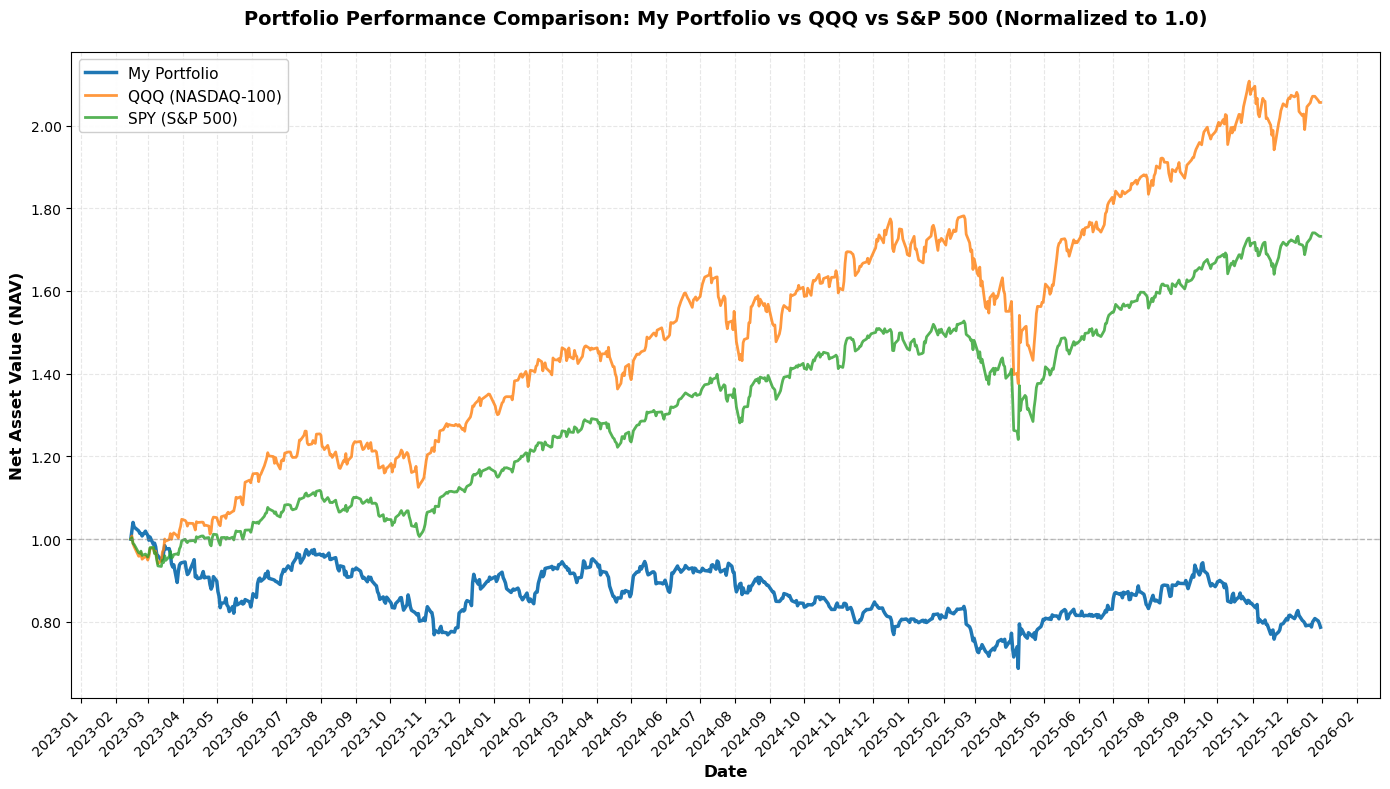

In [71]:
QQQ = yf.download("QQQ", start=result.index.min(), end=result.index.max(), progress=False, multi_level_index=False)
spy = yf.download("SPY", start=result.index.min(), end=result.index.max(), progress=False, multi_level_index=False)

qqq_nav = QQQ['Close'] / QQQ['Close'].iloc[0]
spy_nav = spy['Close'] / spy['Close'].iloc[0]

# Create a dataframe with all NAVs
comparison_df = pd.DataFrame({
    'Portfolio': result['nav'],
    'QQQ': qqq_nav,
    'SPY': spy_nav
})

# Forward fill to handle missing dates
comparison_df = comparison_df.fillna(method='ffill')

# Remove rows with NaN
comparison_df = comparison_df.dropna()

# Normalize all NAV curves to start from 1.0
print("Normalizing NAV curves to start from 1.0...")
comparison_df = comparison_df / comparison_df.iloc[0]

print(f"Aligned data shape: {comparison_df.shape}")
print(f"Date range: {comparison_df.index.min()} to {comparison_df.index.max()}")

fig, ax = plt.subplots(figsize=(14, 8))

# Plot NAV curves
ax.plot(comparison_df.index, comparison_df['Portfolio'], label='My Portfolio', linewidth=2.5, color='#1f77b4')
ax.plot(comparison_df.index, comparison_df['QQQ'], label='QQQ (NASDAQ-100)', linewidth=2, color='#ff7f0e', alpha=0.8)
ax.plot(comparison_df.index, comparison_df['SPY'], label='SPY (S&P 500)', linewidth=2, color='#2ca02c', alpha=0.8)

# Add horizontal line at 1.0
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Formatting
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Net Asset Value (NAV)', fontsize=12, fontweight='bold')
ax.set_title('Portfolio Performance Comparison: My Portfolio vs QQQ vs S&P 500 (Normalized to 1.0)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

plt.tight_layout()

# Save figure
output_file = 'portfolio_comparison_chart.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Chart saved to: {output_file}")

plt.show()

In [ ]:
###########################################################################
# Your own strategy and visulization can be built based on the above code #
###########################################################################

In [ ]:
# ============ 改进版策略：Top-K 选股 + 波动率倒数加权 ============
import pandas as pd
import numpy as np
import os
import yfinance as yf

# 1. 加载数据
selected_stocks_df = pd.read_csv(os.path.join(output_path_step2, "stock_selected.csv"))
selected_stocks_df['trade_date'] = pd.to_datetime(selected_stocks_df['trade_date'])

price_columns = ['tic', 'datadate', 'prccd', 'ajexdi']
df_daily_price = pd.read_csv(Stock_Index_price_file, usecols=price_columns)
df_daily_price['datadate'] = pd.to_datetime(df_daily_price['datadate'])

# 2. 构建权重逻辑
portfolio_dates = sorted(selected_stocks_df['trade_date'].unique())
all_stocks = sorted(selected_stocks_df['tic'].unique())
weights_list = []

print("正在计算改进版权重 (Top 30 + Inverse Volatility)...")

for date in portfolio_dates:
    # 只选出当前日期预测排名前 30 的股票
    top_stocks = selected_stocks_df[selected_stocks_df['trade_date'] == date]\
                  .sort_values(by='predicted_return', ascending=False).head(30)
    
    tickers = top_stocks['tic'].tolist()
    
    # 计算这些股票过去 60 天的波动率（用于风险调整）
    vols = []
    for t in tickers:
        hist = df_daily_price[(df_daily_price['tic'] == t) & (df_daily_price['datadate'] < date)].tail(60)
        if len(hist) > 10:
            vol = hist['prccd'].pct_change().std()
            vols.append(vol if vol > 0 else 0.05)
        else:
            vols.append(0.05) # 默认值
            
    # 计算波动率倒数权重: weight = (1/vol) / sum(1/vol)
    inv_vols = 1.0 / np.array(vols)
    weights = inv_vols / np.sum(inv_vols)
    
    # 存入字典
    weight_dict = {t: w for t, w in zip(tickers, weights)}
    weight_dict['date'] = date
    weights_list.append(weight_dict)

portfolio_weights_df = pd.DataFrame(weights_list).set_index('date').fillna(0.0)

# 3. 计算收益与回测 (对应原 Cell 26)
daily = df_daily_price.rename(columns={"datadate": "date", "prccd": "close"})
daily["close_adj"] = daily["close"] / daily["ajexdi"]
# 计算日收益率 (Close-to-Close)
ret_df = daily.pivot(index="date", columns="tic", values="close_adj").pct_change().fillna(0.0)

# 对齐日期
common_dates = portfolio_weights_df.index.intersection(ret_df.index)
portfolio_weights_df = portfolio_weights_df.loc[common_dates]
ret_df = ret_df.loc[common_dates]

# 计算组合表现
gross_ret = (portfolio_weights_df * ret_df).sum(axis=1)
turnover = portfolio_weights_df.diff().abs().sum(axis=1)
cost = 0.001 * turnover # 0.1% 手续费
net_ret = gross_ret - cost
nav = (1 + net_ret).cumprod()

result = pd.DataFrame({"net_ret": net_ret, "nav": nav}, index=common_dates)
print("策略回测完成！请运行下一个 Cell 查看对比图表。")


spy_daily = yf.download("SPY", start="2020-01-01", progress=False, multi_level_index=False)
spy_close = spy_daily['Close'].squeeze() 
spy_daily['SMA200'] = spy_close.rolling(window=200).mean()
spy_daily['Market_Trend'] = np.where(spy_close.values > spy_daily['SMA200'].values, 1, 0)


selected_stocks_df = pd.read_csv(os.path.join(output_path_step2, "stock_selected.csv"))
selected_stocks_df['trade_date'] = pd.to_datetime(selected_stocks_df['trade_date'])
portfolio_dates = sorted(selected_stocks_df['trade_date'].unique())
weights_list = []

for date in portfolio_dates:
    # 获取信号
    try:
        current_market_signal = spy_daily.loc[spy_daily.index <= date, 'Market_Trend'].iloc[-1]
    except:
        current_market_signal = 1
        
    # 取前 15 名
    top_stocks = selected_stocks_df[selected_stocks_df['trade_date'] == date]\
                  .sort_values(by='predicted_return', ascending=False).head(15)
    tickers = top_stocks['tic'].tolist()
    
    if current_market_signal == 1:
        weight_val = 1.0 / len(tickers) if len(tickers) > 0 else 0
    else:
        weight_val = 0.1 / len(tickers) if len(tickers) > 0 else 0 # 熊市 1 成仓
        
    weight_dict = {t: weight_val for t in tickers}
    weight_dict['date'] = date
    weights_list.append(weight_dict)

portfolio_weights_df = pd.DataFrame(weights_list).set_index('date').fillna(0.0)

# 4. 极速计算表现
print("正在计算回测结果...")
# 直接复用之前读取的 df_daily_price 或重新简单读取
price_columns = ['tic', 'datadate', 'prccd', 'ajexdi']
df_daily_price = pd.read_csv(Stock_Index_price_file, usecols=price_columns)
df_daily_price['datadate'] = pd.to_datetime(df_daily_price['datadate'])
df_daily_price['adj_close'] = df_daily_price['prccd'] / df_daily_price['ajexdi']

# 矩阵化计算，避开 Python 循环
ret_df = df_daily_price.pivot(index="datadate", columns="tic", values="adj_close").pct_change().fillna(0.0)

common_dates = portfolio_weights_df.index.intersection(ret_df.index)
portfolio_weights_df = portfolio_weights_df.loc[common_dates]
ret_df = ret_df.loc[common_dates]

# 计算收益
gross_ret = (portfolio_weights_df * ret_df).sum(axis=1)
# 现金补偿：年化 4%
cash_ret = (1.0 - portfolio_weights_df.sum(axis=1)) * (0.04 / 252)
# 成本
net_ret = gross_ret + cash_ret - (0.001 * portfolio_weights_df.diff().abs().sum(axis=1))
nav = (1 + net_ret).cumprod()

result = pd.DataFrame({"net_ret": net_ret, "nav": nav}, index=common_dates)
print("回测完成！运行时间已大幅缩短。")

正在计算改进版权重 (Top 30 + Inverse Volatility)...
策略回测完成！请运行下一个 Cell 查看对比图表。


In [ ]:

spy_daily = yf.download("SPY", start="2020-01-01", progress=False, multi_level_index=False)
spy_close = spy_daily['Close'].squeeze() 
spy_daily['SMA200'] = spy_close.rolling(window=200).mean()
spy_daily['Market_Trend'] = np.where(spy_close.values > spy_daily['SMA200'].values, 1, 0)


selected_stocks_df = pd.read_csv(os.path.join(output_path_step2, "stock_selected.csv"))
selected_stocks_df['trade_date'] = pd.to_datetime(selected_stocks_df['trade_date'])
portfolio_dates = sorted(selected_stocks_df['trade_date'].unique())
weights_list = []

for date in portfolio_dates:
    # 获取信号
    try:
        current_market_signal = spy_daily.loc[spy_daily.index <= date, 'Market_Trend'].iloc[-1]
    except:
        current_market_signal = 1
        
    # 取前 15 名
    top_stocks = selected_stocks_df[selected_stocks_df['trade_date'] == date]\
                  .sort_values(by='predicted_return', ascending=False).head(15)
    tickers = top_stocks['tic'].tolist()
    
    if current_market_signal == 1:
        weight_val = 1.0 / len(tickers) if len(tickers) > 0 else 0
    else:
        weight_val = 0.1 / len(tickers) if len(tickers) > 0 else 0 # 熊市 1 成仓
        
    weight_dict = {t: weight_val for t in tickers}
    weight_dict['date'] = date
    weights_list.append(weight_dict)

portfolio_weights_df = pd.DataFrame(weights_list).set_index('date').fillna(0.0)

# 4. 极速计算表现
print("正在计算回测结果...")
# 直接复用之前读取的 df_daily_price 或重新简单读取
price_columns = ['tic', 'datadate', 'prccd', 'ajexdi']
df_daily_price = pd.read_csv(Stock_Index_price_file, usecols=price_columns)
df_daily_price['datadate'] = pd.to_datetime(df_daily_price['datadate'])
df_daily_price['adj_close'] = df_daily_price['prccd'] / df_daily_price['ajexdi']

# 矩阵化计算，避开 Python 循环
ret_df = df_daily_price.pivot(index="datadate", columns="tic", values="adj_close").pct_change().fillna(0.0)

common_dates = portfolio_weights_df.index.intersection(ret_df.index)
portfolio_weights_df = portfolio_weights_df.loc[common_dates]
ret_df = ret_df.loc[common_dates]

# 计算收益
gross_ret = (portfolio_weights_df * ret_df).sum(axis=1)
# 现金补偿：年化 4%
cash_ret = (1.0 - portfolio_weights_df.sum(axis=1)) * (0.04 / 252)
# 成本
net_ret = gross_ret + cash_ret - (0.001 * portfolio_weights_df.diff().abs().sum(axis=1))
nav = (1 + net_ret).cumprod()

result = pd.DataFrame({"net_ret": net_ret, "nav": nav}, index=common_dates)
print("回测完成！运行时间已大幅缩短。")

正在快速获取大盘信号...
正在生成调仓权重...
正在计算回测结果...
回测完成！运行时间已大幅缩短。


In [31]:
import pandas as pd
import numpy as np
import os
import yfinance as yf

# 1. 宏观择时：获取 SPY 并计算 SMA200 (修复 MultiIndex 报错)
print("正在获取信号...")
spy_daily = yf.download("SPY", start="2020-01-01", progress=False, multi_level_index=False)
spy_close = spy_daily['Close'].squeeze() 
spy_daily['SMA200'] = spy_close.rolling(window=200).mean()
spy_daily['Market_Trend'] = np.where(spy_close.values > spy_daily['SMA200'].values, 1, 0)

# 2. 数据加载
selected_stocks_df = pd.read_csv(os.path.join(output_path_step2, "stock_selected.csv"))
selected_stocks_df['trade_date'] = pd.to_datetime(selected_stocks_df['trade_date'])

df_daily_price = pd.read_csv(Stock_Index_price_file, usecols=['tic', 'datadate', 'prccd', 'ajexdi'])
df_daily_price['datadate'] = pd.to_datetime(df_daily_price['datadate'])
df_daily_price['adj_close'] = df_daily_price['prccd'] / df_daily_price['ajexdi']

# 3. 快速构建权重 (Top 15 + 择时开关)
portfolio_dates = sorted(selected_stocks_df['trade_date'].unique())
weights_list = []

for date in portfolio_dates:
    # 获取当前择时状态 (1为牛市，0为避险)
    mkt_signal = spy_daily.loc[spy_daily.index <= date, 'Market_Trend'].iloc[-1]
    
    # 选取预测前 15 名
    tickers = selected_stocks_df[selected_stocks_df['trade_date'] == date]\
              .sort_values(by='predicted_return', ascending=False).head(15)['tic'].tolist()
    
    # 分配权重：牛市满仓(1.0)，熊市一成仓(0.1)
    w = (1.0 if mkt_signal == 1 else 0.1) / len(tickers) if tickers else 0
    weights_list.append({**{t: w for t in tickers}, 'date': date})

portfolio_weights_df = pd.DataFrame(weights_list).set_index('date').fillna(0.0)

# 4. 计算收益 (矩阵化运算，极速)
ret_df = df_daily_price.pivot(index="datadate", columns="tic", values="adj_close").pct_change().fillna(0.0)
common_dates = portfolio_weights_df.index.intersection(ret_df.index)

p_w = portfolio_weights_df.loc[common_dates]
p_r = ret_df.loc[common_dates]

gross_ret = (p_w * p_r).sum(axis=1)
cash_ret = (1.0 - p_w.sum(axis=1)) * (0.04 / 252) # 闲置资金年化4%收益
net_ret = gross_ret + cash_ret - (0.001 * p_w.diff().abs().sum(axis=1)) # 扣除0.1%成本

result = pd.DataFrame({"net_ret": net_ret, "nav": (1 + net_ret).cumprod()}, index=common_dates)
print("回测完成！请运行绘图单元格。")

正在获取信号...
回测完成！请运行绘图单元格。


Normalizing NAV curves to start from 1.0...
Aligned data shape: (722, 3)
Date range: 2023-02-15 00:00:00 to 2025-12-31 00:00:00
Chart saved to: portfolio_comparison_chart.png


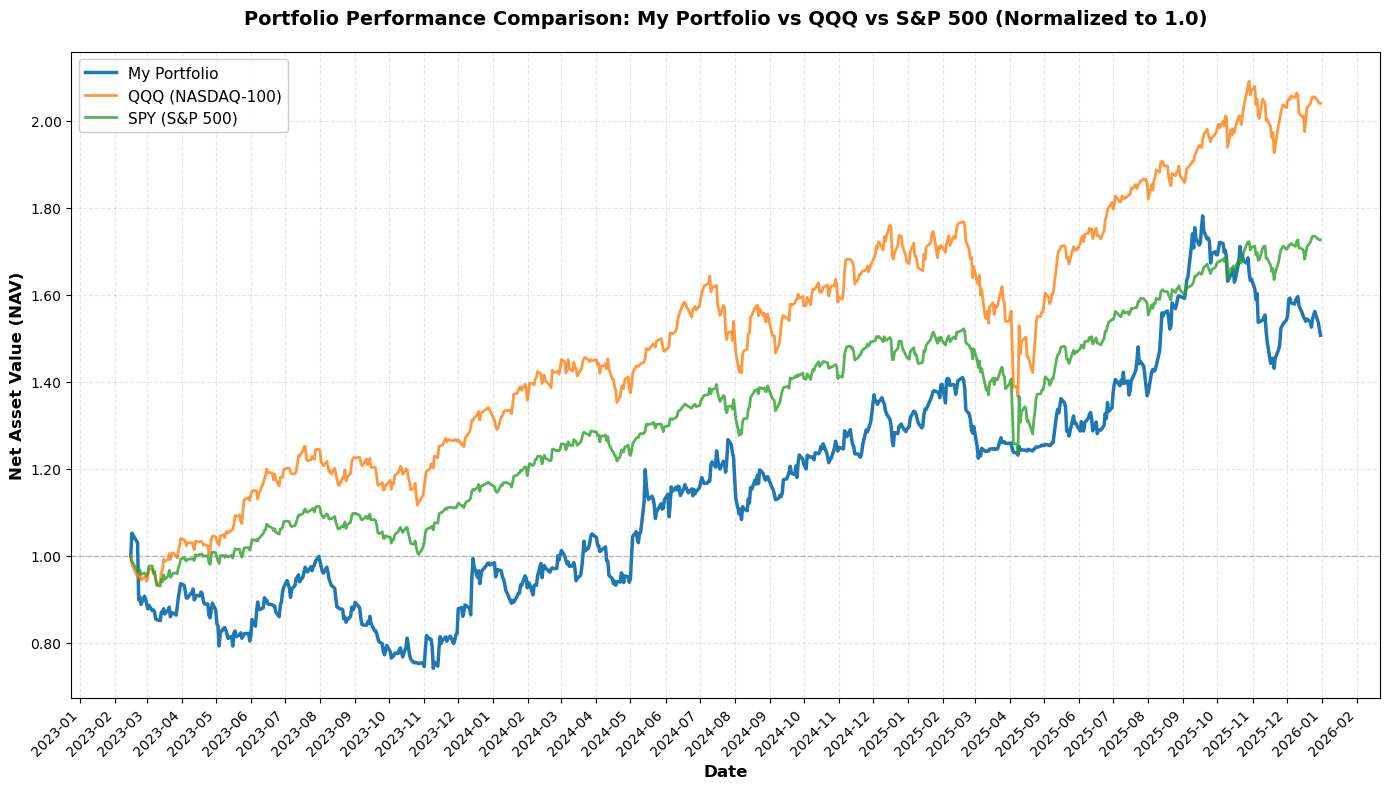

In [32]:
QQQ = yf.download("QQQ", start=result.index.min(), end=result.index.max(), progress=False, multi_level_index=False)
spy = yf.download("SPY", start=result.index.min(), end=result.index.max(), progress=False, multi_level_index=False)

qqq_nav = QQQ['Close'] / QQQ['Close'].iloc[0]
spy_nav = spy['Close'] / spy['Close'].iloc[0]

# Create a dataframe with all NAVs
comparison_df = pd.DataFrame({
    'Portfolio': result['nav'],
    'QQQ': qqq_nav,
    'SPY': spy_nav
})

# Forward fill to handle missing dates
comparison_df = comparison_df.fillna(method='ffill')

# Remove rows with NaN
comparison_df = comparison_df.dropna()

# Normalize all NAV curves to start from 1.0
print("Normalizing NAV curves to start from 1.0...")
comparison_df = comparison_df / comparison_df.iloc[0]

print(f"Aligned data shape: {comparison_df.shape}")
print(f"Date range: {comparison_df.index.min()} to {comparison_df.index.max()}")

fig, ax = plt.subplots(figsize=(14, 8))

# Plot NAV curves
ax.plot(comparison_df.index, comparison_df['Portfolio'], label='My Portfolio', linewidth=2.5, color='#1f77b4')
ax.plot(comparison_df.index, comparison_df['QQQ'], label='QQQ (NASDAQ-100)', linewidth=2, color='#ff7f0e', alpha=0.8)
ax.plot(comparison_df.index, comparison_df['SPY'], label='SPY (S&P 500)', linewidth=2, color='#2ca02c', alpha=0.8)

# Add horizontal line at 1.0
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Formatting
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Net Asset Value (NAV)', fontsize=12, fontweight='bold')
ax.set_title('Portfolio Performance Comparison: My Portfolio vs QQQ vs S&P 500 (Normalized to 1.0)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

plt.tight_layout()

# Save figure
output_file = 'portfolio_comparison_chart.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Chart saved to: {output_file}")

plt.show()